In [24]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
import skopt



def objective_function(x: list):
    dropout_probs = x[0]
    final_layer = x[1]
    in_channels = 1
    CNN_model = VGG16(num_classes=2, in_channels=in_channels, features_fore_linear=36864, dataset=test_set, dropout_probs=dropout_probs, final_layer=final_layer) 
    train_epochs = 1
    train_accs, val_accs = CNN_model.train_model(train_dataloader, epochs=train_epochs)
    acc = CNN_model.eval_model(test_dataloader)
    
    return - acc

with open("opt50.pkl", "rb") as f: 
    opt = pickle.load(f)

with open("rnd_best_params50.pkl", "rb") as f: 
    rnd_best_params = pickle.load(f)

with open("rnd_scores50.pkl", "rb") as f: 
    scores = pickle.load(f)
    
runs = 50
dropout_probs = (0, 0.95)
final_layer = (4000, 8000)

In [25]:
y_data = -opt.func_vals

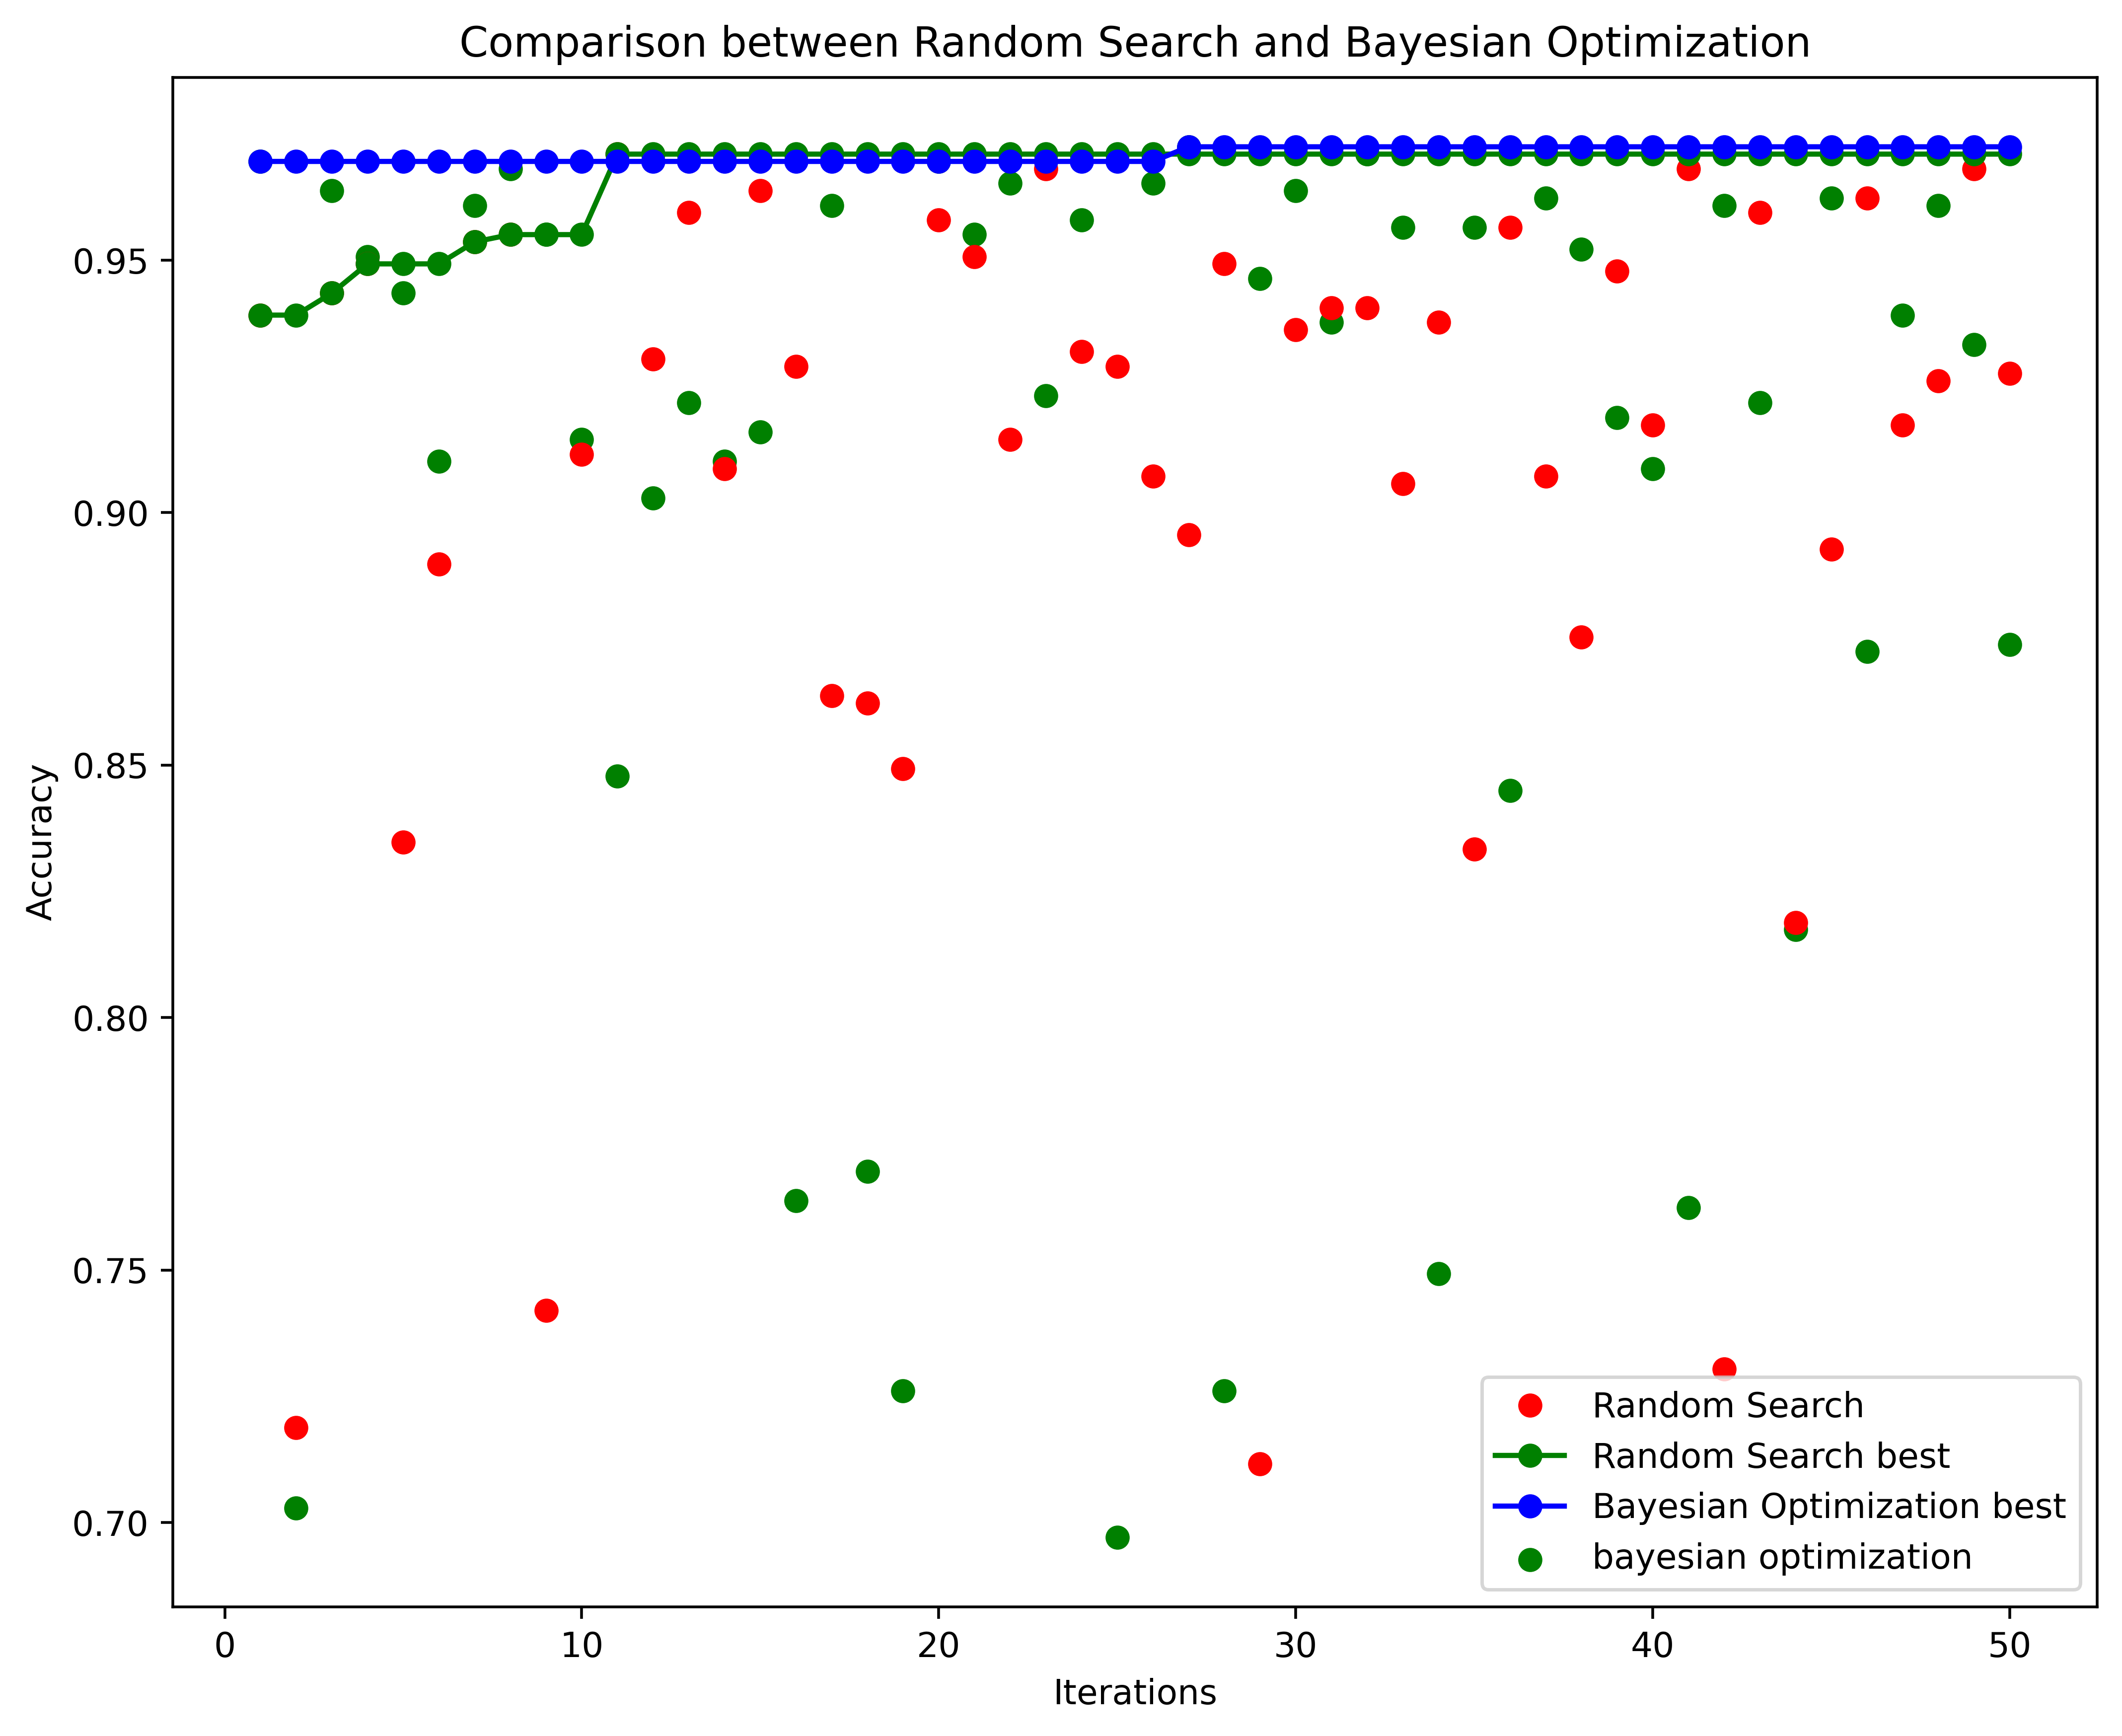

array([0.96956522, 0.96956522, 0.96956522, 0.96956522, 0.96956522,
       0.96956522, 0.96956522, 0.96956522, 0.96956522, 0.96956522,
       0.96956522, 0.96956522, 0.96956522, 0.96956522, 0.96956522,
       0.96956522, 0.96956522, 0.96956522, 0.96956522, 0.96956522,
       0.96956522, 0.96956522, 0.96956522, 0.96956522, 0.96956522,
       0.96956522, 0.97246377, 0.97246377, 0.97246377, 0.97246377,
       0.97246377, 0.97246377, 0.97246377, 0.97246377, 0.97246377,
       0.97246377, 0.97246377, 0.97246377, 0.97246377, 0.97246377,
       0.97246377, 0.97246377, 0.97246377, 0.97246377, 0.97246377,
       0.97246377, 0.97246377, 0.97246377, 0.97246377, 0.97246377])

In [33]:
y_bo = np.maximum.accumulate(-opt.func_vals).ravel()
# define iteration number
xs = np.arange(1,runs+1,1)
x_best = np.maximum.accumulate(-np.array(scores)).ravel()

plt.figure(figsize=(10, 8), dpi=500)
plt.plot(xs, -np.array(scores), 'o', color = 'red', label='Random Search')
plt.plot(xs, x_best, 'o-', color = 'green', label='Random Search best')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization best')
plt.scatter(xs, y_data, color='green', label='bayesian optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

y_bo

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/var/folders/sb/z14jqgvs7ngc7n8kht8p2hpm0000gn/T/ipykernel_25670/1131034159.py:29: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Surrogate function value ($\mu$)')
/var/folders/sb/z14jqgvs7ngc7n8kht8p2hpm0000gn/T/ipykernel_25670/1131034159.py:37: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Surrogate function std dev ($\sigma$)')


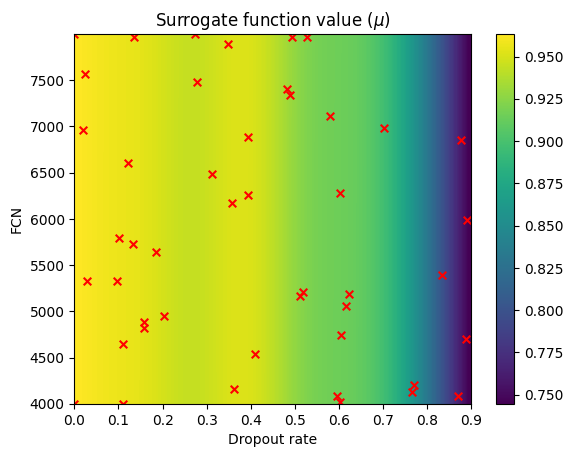

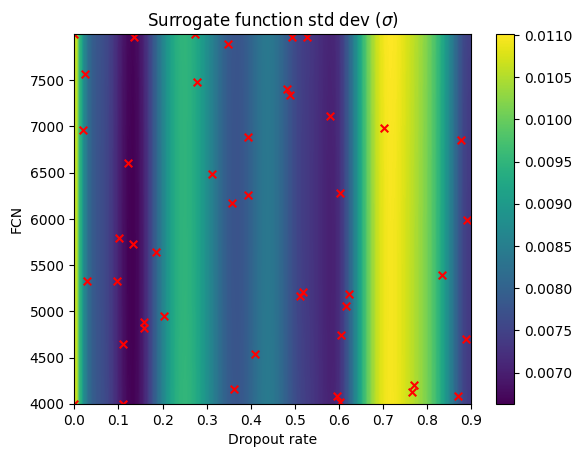

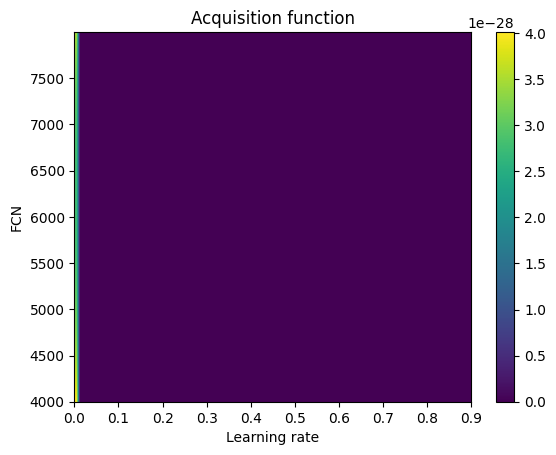

In [27]:

model = opt.models[-1]
pgrid = np.array(np.meshgrid(np.arange(dropout_probs[0],0.91, 0.01), 
                             np.arange(*final_layer), indexing='ij'))
pgrid_norm = np.array([opt.space[i][1].transform(x) for i, x in enumerate(pgrid.reshape(2, -1))])

extra_dims = np.zeros((4, pgrid_norm.shape[1]))
extra_dims[0, :] = 1
pgrid_norm = np.concatenate((pgrid_norm, extra_dims), axis=0)

# Keep only the first two dimensions for plotting
pgrid_norm = pgrid_norm[:2, :]
ye, ye_std = model.predict(X=pgrid_norm.T, return_std=True)

# Reshape outputs to fit the grid structure
ye_img = -np.array(ye).reshape(pgrid[0].shape[:2])
ye_std_img = np.array(ye_std).reshape(pgrid[0].shape[:2])

# For plotting points searched
xx = [i[0] for i in opt.x_iters]
yy = [i[1] for i in opt.x_iters]

# Set up figure
plt.figure()
plt.scatter(xx, yy, c='red', marker='x', label='Optimized points', s=30)
plt.imshow(ye_img.T, origin='lower', extent=[pgrid[0].min(), pgrid[0].max(), pgrid[1].min(), pgrid[1].max()], aspect='auto')
plt.colorbar()  # Set x-axis to log scale
plt.xlabel('Dropout rate')
plt.ylabel('FCN')
plt.title('Surrogate function value ($\mu$)')

plt.figure()
plt.scatter(xx, yy, c='red', marker='x', label='Optimized points', s=30)
plt.imshow(ye_std_img.T, origin='lower', extent=[pgrid[0].min(), pgrid[0].max(), pgrid[1].min(), pgrid[1].max()], aspect='auto')
plt.colorbar() # Set x-axis to log scale
plt.xlabel('Dropout rate')
plt.ylabel('FCN')
plt.title('Surrogate function std dev ($\sigma$)')

plt.show()

#evaluate the acqusition function using skopt.acquisition.gaussian_ei and plot it
acq_val = skopt.acquisition.gaussian_ei(X=pgrid_norm.T, model=model,xi=0.1,y_opt=opt.fun,return_grad=False)
acq_val_img = np.array(acq_val).reshape(pgrid[0].shape[:2])

plt.figure()
plt.imshow(acq_val_img.T, origin='lower', extent=[pgrid[0].min(), pgrid[0].max(), pgrid[1].min(), pgrid[1].max()], aspect='auto')
plt.colorbar()
plt.xlabel('Learning rate')
plt.ylabel('FCN')
plt.title('Acquisition function');